In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import gc

# Clear all cached memory
torch.cuda.empty_cache()
gc.collect()

# Check memory usage
print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
print(f"GPU memory cached: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

GPU memory allocated: 0.00 GB
GPU memory cached: 0.00 GB


In [3]:
import pickle

with open('resized_combined_dataset.pkl', 'rb') as f:
    datasets = pickle.load(f)

In [4]:
with open('resized_combined_dataset_new.pkl', 'rb') as f:
    datasets_new = pickle.load(f)

In [5]:
from sklearn.model_selection import train_test_split

# Split datasets_new into training and testing portions (e.g., 80% train, 20% test)
images_new = [img for img, label in datasets_new]
labels_new = [label for img, label in datasets_new]

images = [img for img, label in datasets]
labels = [label for img, label in datasets]

In [6]:
### combined images and labels
combined_images = images + images_new
combined_labels = labels + labels_new
print(f"Total samples after combining: {len(combined_images)}")

Total samples after combining: 2568


In [7]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Image transformation with augmentation
augmented_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(140),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# Convert combined_images (list of PIL Images) to tensors using augmented_transform
combined_images_tensors = [augmented_transform(img) for img in combined_images]
print(f"Converted {len(combined_images_tensors)} images to tensors. Shape of first tensor: {combined_images_tensors[0].shape}")

Converted 2568 images to tensors. Shape of first tensor: torch.Size([3, 140, 140])


In [8]:
def create_sequence_dataset(images, labels, sequence_length=3):
    """
    Create sequences from individual images
    """
    sequences = []
    seq_labels = []
    
    for i in range(len(images) - sequence_length + 1):
        sequence = combined_images_tensors[i:i+sequence_length]  # Get sequence of images
        
        # Label logic: 1 if any flip occurs in sequence, 0 otherwise
        has_flip = any(labels[i:i+sequence_length])
        
        sequences.append(torch.stack(sequence))
        seq_labels.append(int(has_flip))
    
    return sequences, seq_labels


#Create dataset
sequences, seq_labels = create_sequence_dataset(combined_images_tensors, combined_labels)

In [9]:
# Usage example
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, transform=None):
        self.sequences = sequences
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        
        if self.transform:
            # Apply transform to each frame in sequence
            transformed_sequence = []
            for frame in sequence:
                transformed_sequence.append(self.transform(frame))
            sequence = torch.stack(transformed_sequence)
        
        return sequence, label

In [10]:
# Split sequences and seq_labels into training and validation sets (e.g., 80% train, 20% val) without shuffling
split_idx = int(0.8 * len(sequences))
train_sequences = sequences[:split_idx]
train_seq_labels = seq_labels[:split_idx]
val_sequences = sequences[split_idx:]
val_seq_labels = seq_labels[split_idx:]

In [11]:
print(f"train_sequences shape: {train_sequences[0].shape}")

train_sequences shape: torch.Size([3, 3, 140, 140])


In [12]:
from sklearn.model_selection import train_test_split

# Create datasets and dataloaders for train and validation
train_dataset = SequenceDataset(train_sequences, train_seq_labels)
val_dataset = SequenceDataset(val_sequences, val_seq_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [13]:
len(val_loader.dataset), len(train_loader.dataset)

(514, 2052)

In [14]:
from collections import Counter

# Count label occurrences in training and validation sets
train_label_counts = Counter(train_seq_labels)
val_label_counts = Counter(val_seq_labels)

print("Training set label counts:", train_label_counts)
print("Validation set label counts:", val_label_counts)

Training set label counts: Counter({1: 1755, 0: 297})
Validation set label counts: Counter({1: 455, 0: 59})


### Training a CNN+LSTM model to detect page flips in a sequence.
* Facing the following problem:
* If the sequence is long, the chances of a page flip in the sequence increases. resulting in very less examples of sequences without a page flip, causing problem in training.
* If the sequence is small, the LSTM is having problems learning.
* Settled on a sequence length of 3 for the experiments.

In [21]:
class CNN_LSTM_FlipDetector(nn.Module):
    def __init__(self, hidden_size=64):
        super(CNN_LSTM_FlipDetector, self).__init__()
        
        # CNN feature extractor (per frame)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.feature_size = 32 * 35 * 35
        
        # Reduce feature dimensionality
        self.feature_fc = nn.Linear(self.feature_size, 128)
        
        # LSTM for sequence processing
        self.lstm = nn.LSTM(128, hidden_size, batch_first=True, num_layers=2)

        # Final classifier
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, x):
        # x shape: (batch, sequence_length, channels, height, width)
        batch_size, seq_len = x.size(0), x.size(1)
        
        # Process each frame through CNN
        features = []
        for i in range(seq_len):
            frame = x[:, i]  # (batch, 3, 140, 140)
            
            # CNN feature extraction
            feat = self.pool(F.relu(self.conv1(frame)))
            feat = self.pool(F.relu(self.conv2(feat)))
            feat = feat.view(batch_size, -1)
            feat = F.relu(self.feature_fc(feat))
            
            features.append(feat)
        
        # Stack features: (batch, sequence_length, feature_dim)
        features = torch.stack(features, dim=1)
        
        # LSTM processing
        lstm_out, _ = self.lstm(features)
        
        # Use last output for classification
        output = self.classifier(lstm_out[:, -1])
        
        return output

In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_FlipDetector(hidden_size=128).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

num_epochs = 60
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    for batch_idx, (sequences, labels) in enumerate(train_loader):
        # sequences shape: (batch, seq_len, channels, height, width)
        sequences = sequences.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * sequences.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    #Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss= 0 
    correct = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * sequences.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_acc = correct / len(val_loader.dataset)

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")


Epoch 1/60 - Train Loss: 0.4244 - Val Loss: 0.3629 - Val Acc: 0.8852
Epoch 11/60 - Train Loss: 0.4162 - Val Loss: 0.3566 - Val Acc: 0.8852
Epoch 21/60 - Train Loss: 0.4143 - Val Loss: 0.3586 - Val Acc: 0.8852
Epoch 31/60 - Train Loss: 0.4152 - Val Loss: 0.3604 - Val Acc: 0.8852
Epoch 41/60 - Train Loss: 0.4139 - Val Loss: 0.3636 - Val Acc: 0.8852
Epoch 51/60 - Train Loss: 0.4140 - Val Loss: 0.3575 - Val Acc: 0.8852


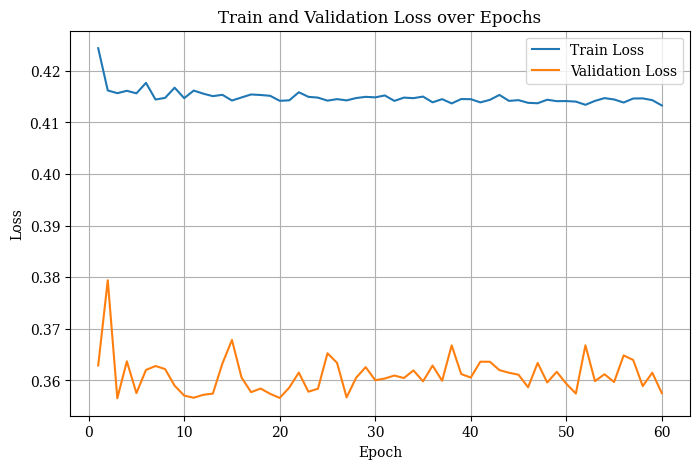

In [23]:
import matplotlib.pyplot as plt


# If you already have train_losses and val_losses lists, plot them:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.89      1.00      0.94       455

    accuracy                           0.89       514
   macro avg       0.44      0.50      0.47       514
weighted avg       0.78      0.89      0.83       514



c:\Users\samar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

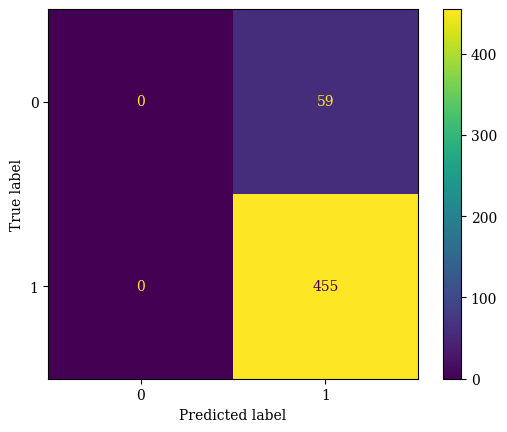

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'serif'

# Get predictions for the entire validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for sequences, labels in val_loader:
        sequences = sequences.to(device)
        outputs = model(sequences)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [25]:
for batch_idx, (sequences, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Sequence shape: {sequences.shape}")
    print(f"  Labels shape: {labels.shape}")
    break

Batch 1:
  Sequence shape: torch.Size([16, 3, 3, 140, 140])
  Labels shape: torch.Size([16])


In [26]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=64):
        super(CNNFeatureExtractor, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # For input shape [batch, 3, 64, 64], after two poolings: [batch, 32, 16, 16]
        self.feature_size = 32 * 35 * 35
        
        self.linear = nn.Linear(self.feature_size, feature_dim)
        
    def forward(self, x):
        # x: [batch, 3, 64, 64]
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 16, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 32, 16, 16]
        x = x.view(x.size(0), -1)             # [batch, 32*16*16]
        x = F.relu(self.linear(x))            # [batch, feature_dim]
        return x

### A XGBoost model is trained next by using differences in features across frames in a sequence as well as using statistical aggregeations of the features in the different frames of a sequence.

In [27]:
from xml.parsers.expat import model
import joblib   
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.utils import compute_class_weight
import xgboost as xgb
import numpy as np
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'

class SimpleFlipDetector:
    def __init__(self, feature_dim=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.cnn = CNNFeatureExtractor(feature_dim)  # Initialize model
        self.cnn.to(self.device)
        self.xgb_model = None
        self.feature_dim = feature_dim
        
    def extract_features(self, sequences):
        self.cnn.eval()
        batch_size, seq_len = sequences.size(0), sequences.size(1)
    
         # Add this line:
        sequences = sequences.to(self.device)
        all_features = []
        with torch.no_grad():
            for i in range(seq_len):
                frame = sequences[:, i]
                features = self.cnn(frame)
                all_features.append(features)

        stacked_features = torch.cat(all_features, dim=1)  # [batch, seq_len, feature_dim]
        features_tensor = torch.stack(all_features, dim=1)  # [batch, seq_len, feature_dim]
            
        # Statistical aggregations across sequence
        mean_features = torch.mean(features_tensor, dim=1)  # [batch, feature_dim]
        max_features = torch.max(features_tensor, dim=1)[0]  # [batch, feature_dim] 
        min_features = torch.min(features_tensor, dim=1)[0]  # [batch, feature_dim]
        std_features = torch.std(features_tensor, dim=1)     # [batch, feature_dim]
            
        # Consecutive differences (temporal changes)
        diff_list = []
        abs_diff_list = []
        for i in range(seq_len - 1):
            diff = all_features[i+1] - all_features[i]
            diff_list.append(diff)
            abs_diff_list.append(torch.abs(diff))
            
        # Aggregate differences
        if diff_list:
            diff_tensor = torch.stack(diff_list, dim=1)  # [batch, seq_len-1, feature_dim]
            mean_diff = torch.mean(diff_tensor, dim=1)   # [batch, feature_dim]
            max_diff = torch.max(diff_tensor, dim=1)[0]  # [batch, feature_dim]
            std_diff = torch.std(diff_tensor, dim=1)     # [batch, feature_dim]
                
            abs_diff_tensor = torch.stack(abs_diff_list, dim=1)
            mean_abs_diff = torch.mean(abs_diff_tensor, dim=1)
            max_abs_diff = torch.max(abs_diff_tensor, dim=1)[0]
        else:
            mean_diff = max_diff = std_diff = torch.zeros_like(mean_features)
            mean_abs_diff = max_abs_diff = torch.zeros_like(mean_features)
            
        # Combine all features
        enhanced_features = torch.cat([
            stacked_features,     # [batch, seq_len * feature_dim] - original
            mean_features,        # [batch, feature_dim] - mean across frames
            max_features,         # [batch, feature_dim] - max across frames
            min_features,         # [batch, feature_dim] - min across frames
            std_features,         # [batch, feature_dim] - std across frames
            mean_diff,            # [batch, feature_dim] - mean difference
            max_diff,             # [batch, feature_dim] - max difference
            std_diff,             # [batch, feature_dim] - std of differences
            mean_abs_diff,        # [batch, feature_dim] - mean absolute difference
            max_abs_diff          # [batch, feature_dim] - max absolute difference
        ], dim=1)
        
        return enhanced_features.cpu().numpy()
        return stacked_features.cpu().numpy()  # Move back to CPU for numpy
    
    def train(self, sequences, labels):
        """
        Train the model
        
        Args:
            sequences: [batch, seq_len, 3, 224, 224]
            labels: [batch]
        """
        # Extract features
        features = self.extract_features(sequences)
        labels_np = labels.numpy()
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels_np, test_size=0.2, random_state=42
        )
        
        classes = np.unique(y_train)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

        # Train XGBoost
        self.xgb_model = xgb.XGBClassifier(
            n_estimators=2000,
            max_depth=None,
            colsample_bytree=0.8,
            learning_rate=0.1,
            random_state=42,
            reg_lambda=1.0,
            reg_alpha=0.0
        )

        # self.logreg_model = LogisticRegression(
        #     max_iter=1000,
        #     random_state=42
        # )

        # Store results
        weights_list = np.arange(0.01, 0.5, 0.03)
        accuracies = []
        cms = []

        for w in weights_list:
            # Assign sample weights: positive class gets weight w, negative gets 1
            sample_weights = np.where(y_train == 1, w, 1)
            # Fit a new model with the same hyperparameters but different sample weights
  
            self.xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
            y_pred = self.xgb_model.predict(X_test)
            accuracies.append(accuracy_score(y_test, y_pred))
            cm = confusion_matrix(y_test, y_pred)
            cms.append(cm)

        len_weights = len(weights_list)
        print(f"Number of weights evaluated: {len_weights}")

        # Plot confusion matrices

        fig, axes = plt.subplots(4, 5, figsize=(18, 18))
        axes = axes.flatten()
        for idx, (w, cm) in enumerate(zip(weights_list, cms)):
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
            disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
            axes[idx].set_title(f'Sample weight (pos): {w:.2f}\n Acc: {accuracies[idx]:.2f}')
        plt.tight_layout()
        plt.show()

        best_train_acc = max(accuracies)
        best_weight = weights_list[np.argmax(accuracies)]
        joblib.dump(self.xgb_model, 'xgb_flip_detector.pkl')
        test_acc = self.xgb_model.score(X_test, y_test)
        
        print(f"Train Accuracy: {best_train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        
        return best_train_acc, test_acc
    
    def train_best(self, sequences, labels, w):
        """
        Train the model
        
        Args:
            sequences: [batch, seq_len, 3, 224, 224]
            labels: [batch]
        """
        # Extract features
        features = self.extract_features(sequences)
        labels_np = labels.numpy()
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels_np, test_size=0.2, random_state=42
        )
        
        classes = np.unique(y_train)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

        # Train XGBoost
        self.xgb_model = xgb.XGBClassifier(
            n_estimators=1000,
            max_depth=None,
            colsample_bytree=0.8,
            learning_rate=0.1,
            random_state=42,
            reg_lambda=1.0,
            reg_alpha=0.0
        )

        sample_weights = np.where(y_train == 1, w, 1)
        self.xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = self.xgb_model.predict(X_test)


    
    def predict(self, sequences):
        """Predict flip for sequences"""
        features = self.extract_features(sequences)
        predictions = self.xgb_model.predict(features)
        probabilities = self.xgb_model.predict_proba(features)
        return predictions, probabilities

Number of weights evaluated: 17


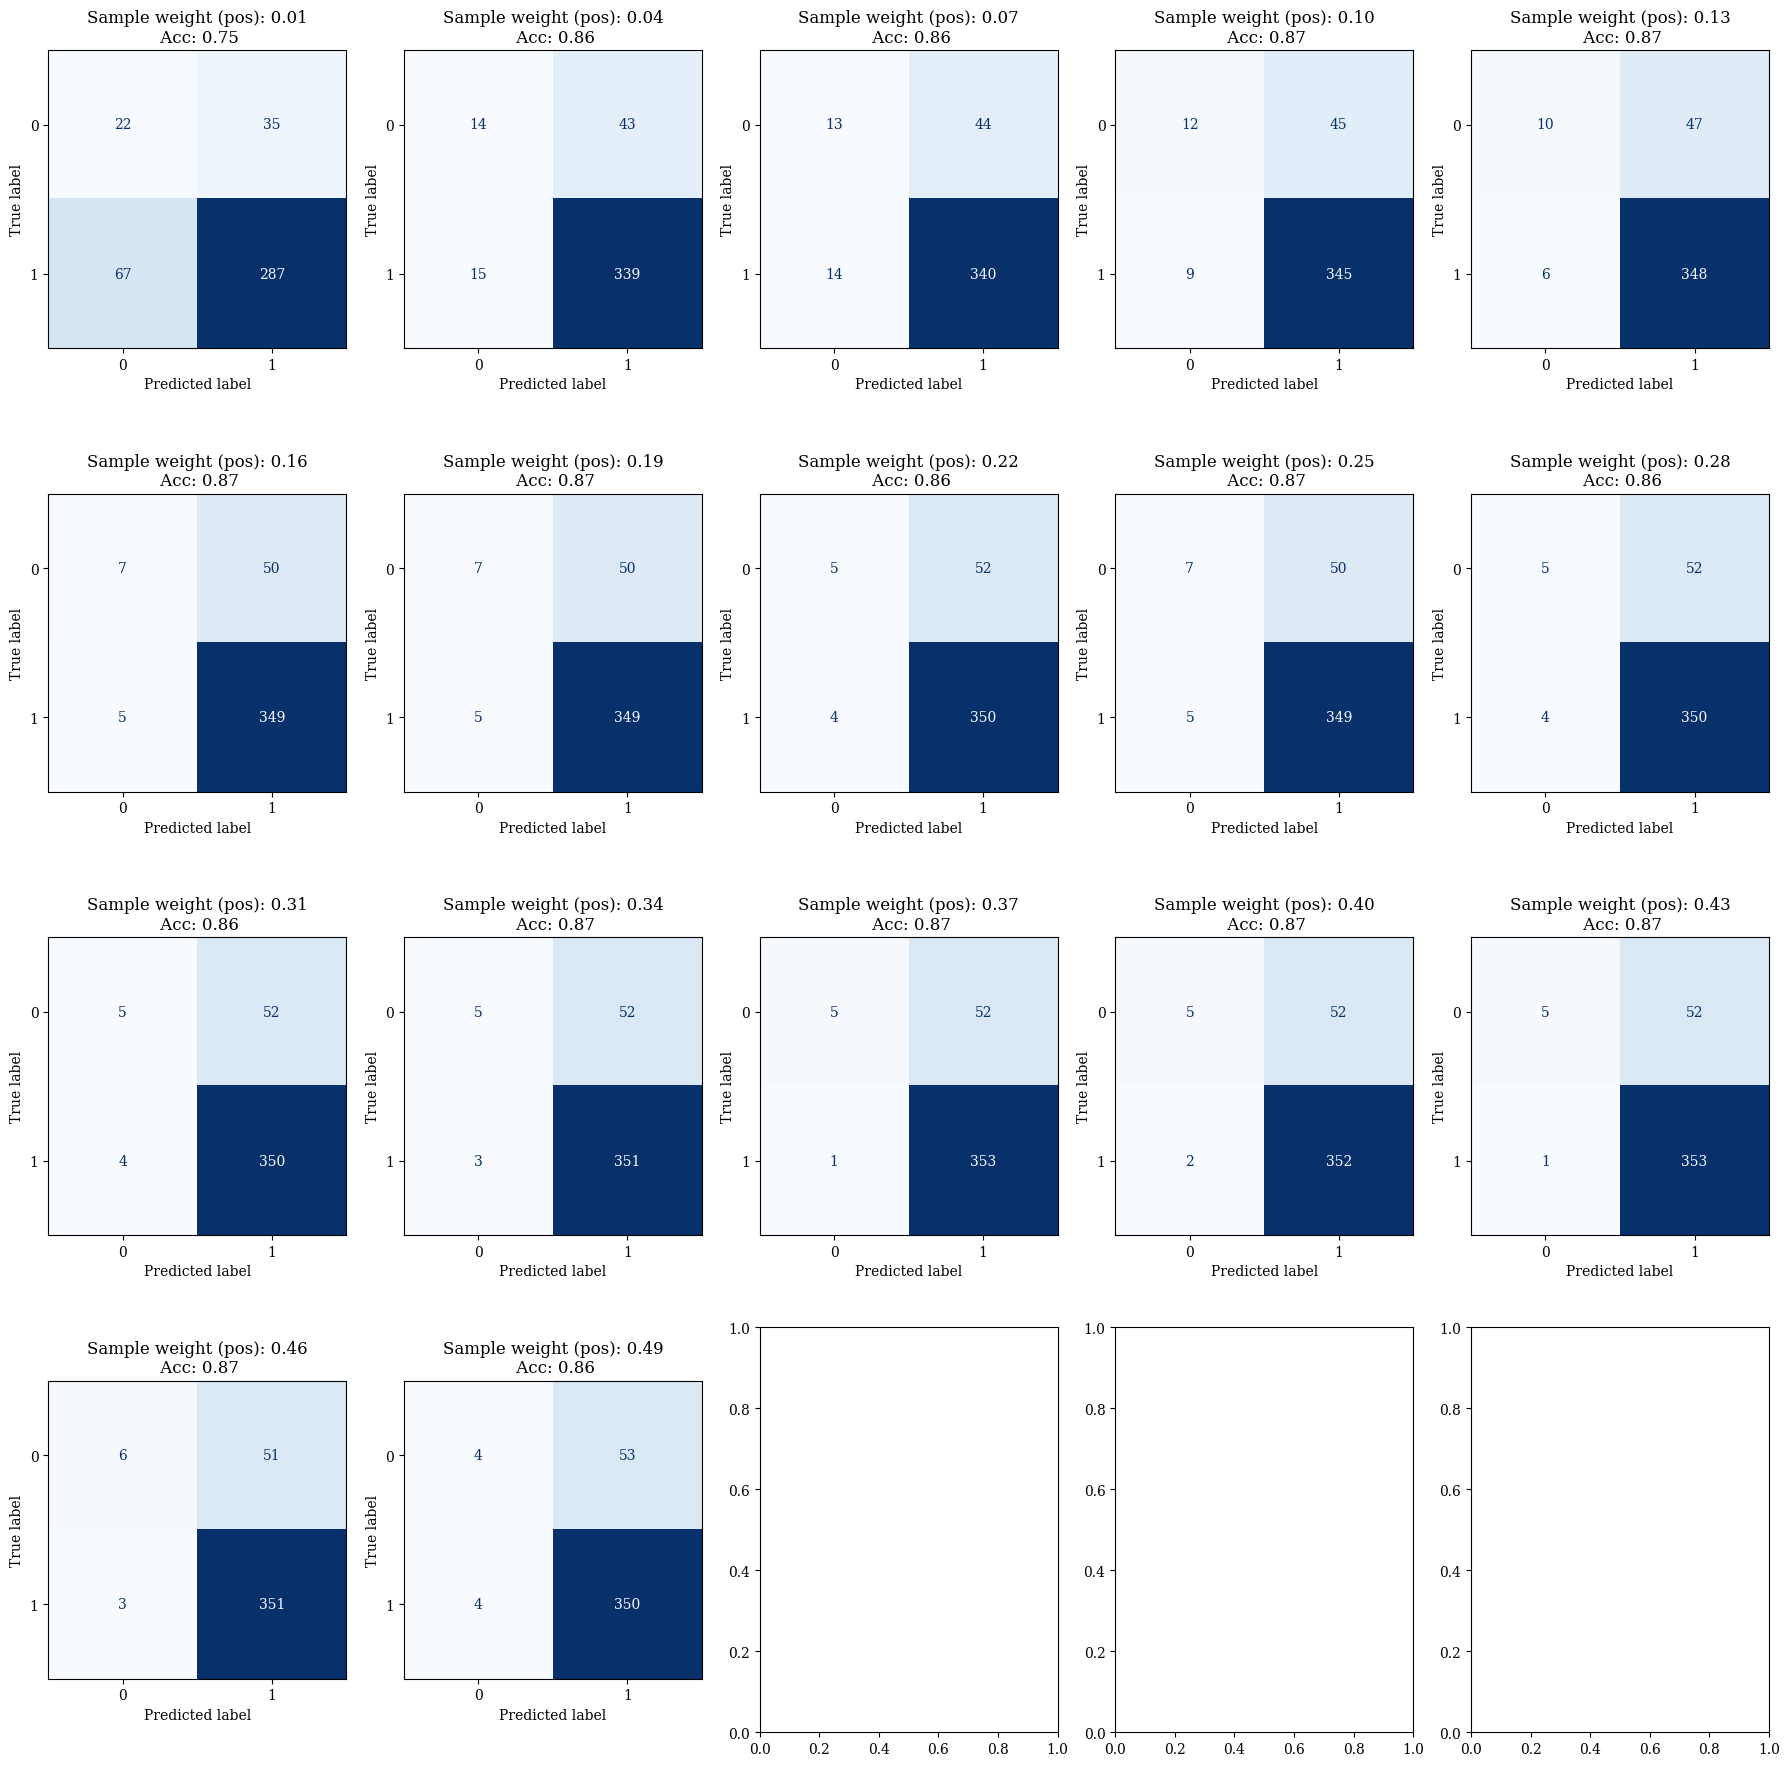

Train Accuracy: 0.8710
Test Accuracy: 0.8613


(0.8710462287104623, 0.8613138686131386)

In [28]:
import numpy as np
import xgboost as xgb # type: ignore

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare data for SimpleFlipDetector
# Convert train_sequences and val_sequences (list of tensors) to a single tensor
train_seq_tensor = torch.stack(train_sequences)  # shape: [N_train, seq_len, 3, 224, 224]
train_labels_tensor = torch.tensor(train_seq_labels)

val_seq_tensor = torch.stack(val_sequences)  # shape: [N_val, seq_len, 3, 224, 224]
val_labels_tensor = torch.tensor(val_seq_labels)

# Initialize SimpleFlipDetector
simple_detector = SimpleFlipDetector(feature_dim=64)

# Train the model on training set
simple_detector.train(train_seq_tensor, train_labels_tensor)


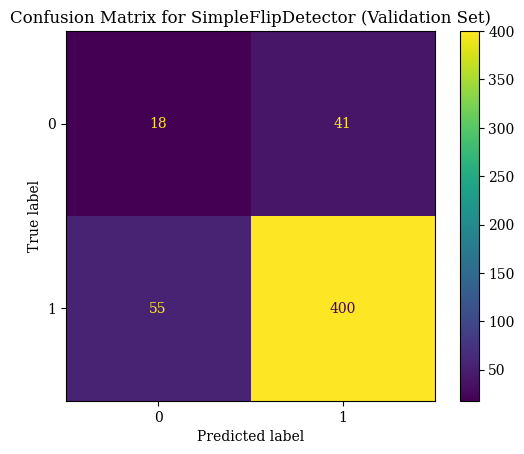

              precision    recall  f1-score   support

           0       0.25      0.31      0.27        59
           1       0.91      0.88      0.89       455

    accuracy                           0.81       514
   macro avg       0.58      0.59      0.58       514
weighted avg       0.83      0.81      0.82       514



In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Prepare validation data for SimpleFlipDetector
val_seq_tensor = torch.stack(val_sequences)  # shape: [N_val, seq_len, 3, 64, 64]

simple_detector.train_best(train_seq_tensor, train_labels_tensor, w=0.017)

val_predictions, _ = simple_detector.predict(val_seq_tensor)

# Get true labels
val_labels_np = val_labels_tensor.numpy()

# Compute confusion matrix
plt.rcParams['font.family'] = 'serif'
cm = confusion_matrix(val_labels_np, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for SimpleFlipDetector (Validation Set)")
plt.show()

# Print classification report
print(classification_report(val_labels_np, val_predictions))